In [1]:
import requests
import re
import io
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime
# from PyPDF2 import PdfFileReader
from pdfminer.high_level import extract_text
import logging
import sys
import pandas as pd


logger = logging.getLogger() 
logger.handlers = [logging.StreamHandler()]
logger.setLevel(logging.INFO)


In [2]:
csv_file = '../data/who-global-cases.csv'
png_file = '../images/who-global-cases.png'

In [3]:
# display the last execute time
datetime.now()

datetime.datetime(2020, 4, 21, 20, 7, 25, 279042)

### Scraping

In [4]:
def analyze_report(url):
    '''
    Analyze a situation report url
    '''
    response = requests.get(url)
    # approach using Py2PDF
    #     f_obj = io.BytesIO(response.content)
    #     pdf = PdfFileReader(f_obj)
    #     page_zero = pdf.getPage(0)  
    #     text  = page_zero.extractText()

    # using pdfminer
    filename=re.sub("[\:\s\.]", "", str(datetime.now()))
    open(filename, "wb").write(response.content)
    text = extract_text(filename)
    
    try:
        # use regular expression to extract date
        p_date = re.compile("Data as .+ by .+ (\d+ \w+ 202\d)")
        m_date = p_date.search(text)
        print(m_date)
        report_date_str = m_date.group(1).replace("\n","")
        print(report_date_str, m_date.group(1))
        report_date = datetime.strptime(report_date_str, '%d %B %Y').strftime('%Y-%m-%d')
        print(report_date)
        # use regular expression to extract global cases
        p_global = re.compile("Globally ([\s\n0-9]+)", re.DOTALL)
        m_global = p_global.search(text)
        global_cases_str = re.sub(r'[\n\s]', '', m_global.group(1))

        global_cases = int(global_cases_str)

        return {"date":report_date, "global_cases": global_cases, "report_url": url}
    except AttributeError as e:
        logger.warning(f'Unable to extract from "{url}" : {e}\n.')
        raise e



In [5]:
def get_reports_urls(home_url):
    '''
    Extract situation reports URL from WHO's page
    '''
    # unable to analyse these reports
    skipped_urls = [
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200126-sitrep-6-2019--ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200125-sitrep-5-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200124-sitrep-4-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200123-sitrep-3-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200122-sitrep-2-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200121-sitrep-1-2019-ncov.pdf'
    ]  
    
    urls = []
    response = requests.get(home_url)
    soup = BeautifulSoup(response.content, 'lxml')
    tags = soup.find_all('a')
    for tag in tags:
        if len(tag.contents)>0:
            content = str(tag.contents[0])
            if "Situation report - " in content:
                url = urljoin(home_url ,  tag.get('href')).split('?')[0]
                
                if url not in skipped_urls:
                    urls.append(url)

    return urls


In [6]:
def get_WHO_stats():
    reports_home_url = 'https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/'
    reports_urls = get_reports_urls(reports_home_url)
    df = pd.read_csv(csv_file)
    for url in reports_urls:
        if df['report_url'].str.contains(url).any():
            print('already processed ', url, ' in previous runs')
            continue
        stats = analyze_report(url)
        df = df.append(stats, ignore_index = True)
    return df

In [7]:
reports_urls = get_reports_urls('https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports')
df = pd.read_csv(csv_file)
print(reports_urls)
print(df['report_url'])

['https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200421-sitrep-92-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200420-sitrep-91-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200419-sitrep-90-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200418-sitrep-89-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200417-sitrep-88-covid-191b6cccd94f8b4f219377bff55719a6ed.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200416-sitrep-87-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200415-sitrep-86-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200414-sitrep-85-covid-19.pdf', 'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200413-sitrep-84-covid-19.pdf', 'https://www.

In [8]:
df = get_WHO_stats()

xref found: pos=b'1244264'
read_xref_from: start=1244264, token=/b'xref'
xref objects: {}
trailer: {'Size': 3887, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:102>, 'ID': [b'1\xe0\xb9q\xa1O`H\x86\\\x8b\xd6\xfdLU\xcc', b'1\xe0\xb9q\xa1O`H\x86\\\x8b\xd6\xfdLU\xcc'], 'Prev': 1166360, 'XRefStm': 1158925}
read_xref_from: start=1158925, token=3886
xref stream: objid=(0, 3886), fields=1,4,2
trailer: {'Type': /'XRef', 'Size': 3886, 'W': [1, 4, 2], 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:102>, 'ID': [b'1\xe0\xb9q\xa1O`H\x86\\\x8b\xd6\xfdLU\xcc', b'1\xe0\xb9q\xa1O`H\x86\\\x8b\xd6\xfdLU\xcc'], 'Filter': /'FlateDecode', 'Length': 7228}
read_xref_from: start=1166360, token=/b'xref'
xref objects: {1: (None, 17, 0), 2: (None, 171, 0), 3: (None, 305, 0), 4: (None, 761, 0), 5: (None, 8165, 0), 6: (None, 8327, 0), 7: (None, 8553, 0), 8: (None, 8606, 0), 9: (None, 8659, 0), 10: (None, 8830, 0), 11: (None, 9072, 0), 12: (None, 9246, 0), 13: (None, 9483, 0), 14: (None, 9654, 0), 15: (None, 9890, 0), 16: (No

<re.Match object; span=(70, 150), match='Data as receiv ed by WHO from national authoritie>
21 April 2020 21 April 2020
2020-04-21
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200420-sitrep-91-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200419-sitrep-90-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200418-sitrep-89-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200417-sitrep-88-covid-191b6cccd94f8b4f219377bff55719a6ed.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200416-sitrep-87-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200415-sitrep-86-covid-19.pdf  in previous ru

In [9]:
df

,date,global_cases,report_url
0,2020-01-27,2798,https://www.who.int/docs/default-source/corona...
1,2020-01-28,4593,https://www.who.int/docs/default-source/corona...
2,2020-01-29,6065,https://www.who.int/docs/default-source/corona...
3,2020-01-30,7818,https://www.who.int/docs/default-source/corona...
4,2020-01-31,9826,https://www.who.int/docs/default-source/corona...
...,...,...,...
84,2020-04-17,2074529,https://www.who.int/docs/default-source/corona...
85,2020-04-18,2160207,https://www.who.int/docs/default-source/corona...
86,2020-04-19,2241359,https://www.who.int/docs/default-source/corona...
87,2020-04-20,2314621,https://www.who.int/docs/default-source/corona...


### Plot graph and save to files

In [10]:
import seaborn as sns
from pathlib import Path

In [11]:
df.sort_values(by=['date'], inplace=True)

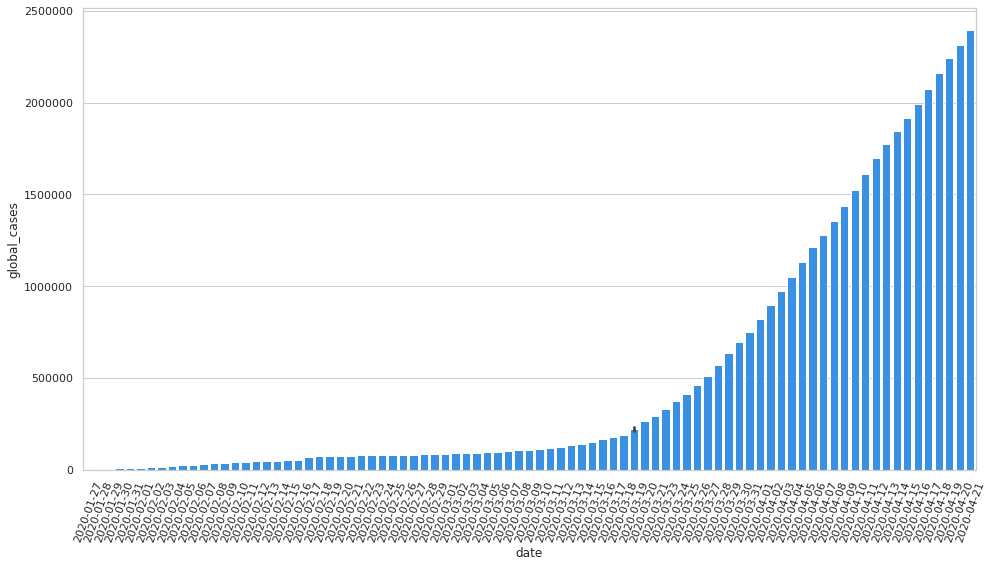

In [12]:
sns.set(rc={'figure.figsize':(16,8.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='global_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [13]:
bar_chart_fig = bar_chart.get_figure()


In [14]:
df.to_csv(csv_file, index=False)
bar_chart_fig.savefig(png_file)
